# Understanding the CIFAR-10 dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images.

Acknowledgements: https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

Extracts data from the dataset, then split them into training and cross validation sets. Afterwards, we feed the data into Pytorch `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes.

`Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tarfile

with tarfile.open('./drive/MyDrive/cifar-10-python.tar.gz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
import os

data_dir = './data/cifar-10-batches-py/'
print(os.listdir(data_dir))

['data_batch_4', 'data_batch_1', 'batches.meta', 'readme.html', 'data_batch_3', 'data_batch_2', 'test_batch', 'data_batch_5']


In [5]:
def unpickle(file, encode='bytes'):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding=encode)
    return dict

In [6]:
dict_batch_1 = unpickle('./data/cifar-10-batches-py/data_batch_1')
dict_batch_2 = unpickle('./data/cifar-10-batches-py/data_batch_2')
dict_batch_3 = unpickle('./data/cifar-10-batches-py/data_batch_3')
dict_batch_4 = unpickle('./data/cifar-10-batches-py/data_batch_4')
dict_batch_5 = unpickle('./data/cifar-10-batches-py/data_batch_5')

test_batch = unpickle('./data/cifar-10-batches-py/test_batch')
train_batch = [dict_batch_1, dict_batch_2, dict_batch_3, dict_batch_4, dict_batch_5]



In [103]:
train_data = []
train_label = []
for dict_batch in train_batch:
  # Given each batch has 10000 samples, we reshape to NCHW
  data_batch = dict_batch[b'data'].reshape(10000, 3, 32, 32) 
  labels_batch = np.array(dict_batch[b'labels'])
  train_data.append(data_batch)
  train_label.append(labels_batch)

X_train = np.concatenate(train_data, axis=0)
y_train = np.concatenate(train_label)

X_train.shape, y_train.shape

((50000, 3, 32, 32), (50000,))

In [8]:
# convert to torch tensor
X_train = torch.from_numpy(X_train).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32)

X_train.shape, y_train.shape
X_train.dtype, y_train.dtype

(torch.float32, torch.float32)

In [70]:
from sklearn.model_selection import train_test_split

# define device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# split data into training and cross validation set
X_train, X_val, y_train, y_val = train_test_split(X_train.to(DEVICE), y_train.to(DEVICE), test_size=0.2)
X_train.shape, y_train.shape 

(torch.Size([25600, 3, 32, 32]), torch.Size([25600]))

From `batches.meta` file we extract the 10 class names and store them in the list `name_labels`. Images are indexed range 0-9, which maps to the indices of the list `name_labels`.

In [71]:
# list of name labels/classes, indexed
name_labels_dict = unpickle('./data/cifar-10-batches-py/batches.meta', encode='latin1')
name_labels = name_labels_dict['label_names']
print(name_labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [72]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# here we write a custom Dataset class to feed data into the DataLoader class

class CIFAR10Custom(Dataset):
  def __init__(self, X_params: torch.Tensor, y_params: torch.Tensor, transform=None):
    self.X_params = X_params.to(DEVICE)
    self.y_params = y_params.to(DEVICE)
    self.transform = transform
  
  def __len__(self):
    return len(self.y_params)
  
  def __getitem__(self, index: int):
    if self.transform:
      return self.transform(self.X_params[index].type(torch.uint8)), self.y_params[index].type(torch.uint8)
    else:
      return self.X_params[index].type(torch.uint8), self.y_params[index].type(torch.uint8)

Feature augmentation can increase the diversity of training examples. `torchvision.transforms.TrivialAugmentWide` provides arbitrary transformations to image tensors/PIL Image.

In [73]:
# we feature engineering by writing a set of transformations (augmentations to image tensor)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=3),
])

train_dataset = CIFAR10Custom(X_train, y_train, train_transform)
val_dataset = CIFAR10Custom(X_val, y_val)

In [74]:
import os
from torch.utils.data import DataLoader

# feed datasets into DataLoader class
torch.manual_seed(42)
torch.cuda.manual_seed(42)

train_dl = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)

val_dl = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)


For a sanity check, we can verify that the dataset is loaded correctly by generating random images from the dataset and check if the label matches.

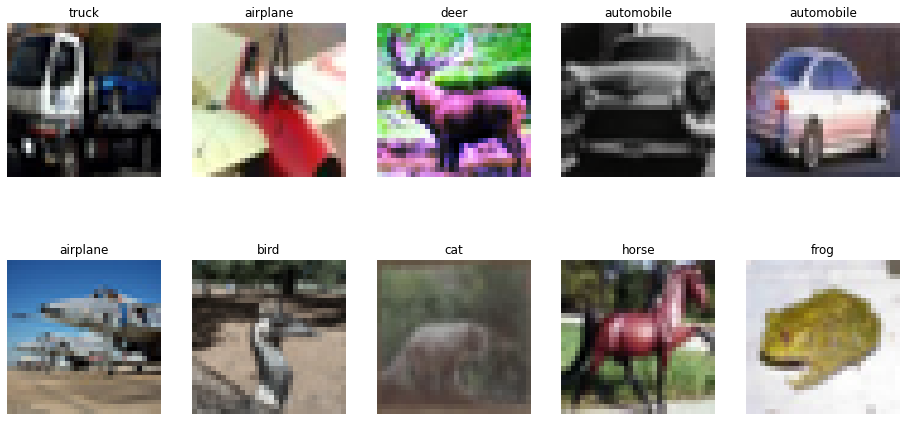

In [75]:
import random

# get a visualisation of data, 10 random images shown 
def generate_images(dataset=train_dataset, name_labels=name_labels):
  indexes = random.sample(range(len(dataset)), k=10)
  plt.figure(figsize=(16,8))

  for plot_index, sample_pt in enumerate(indexes):
    img, label_idx = dataset[sample_pt][0], dataset[sample_pt][1]
    plt.subplot(2, 5, plot_index + 1)
    plt.imshow(img.cpu().permute(1, 2, 0)) # permutes from C,H,W to H,W,C
    plt.axis(False)
    plt.title(name_labels[label_idx])

generate_images(dataset=train_dataset)

## Model Definition

We proceed to set up helper functions for our model, followed by defining 2 CNN models, `TinyVGG` and `VGG3`. Then we will set up the training loop function `fit`.

In [76]:
from torch import nn

# define device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# hyperparameters in our model
loss_func = nn.CrossEntropyLoss()
opt_func = torch.optim.Adam
lr = 0.001

# we define helper methods in a ImageClassificationBase used in our model

class ImageClassificationBase(nn.Module):
  def train_step(self, batch):
    X_image, y_label = batch
    X_image, y_label = X_image.type(torch.float32).to(DEVICE), y_label.to(DEVICE)
    out = self(X_image)             # Generate predictions    
    loss = loss_func(out, y_label)  # Calculate loss per batch
    return loss

  def validation_step(self, batch):
    X_image, y_label = batch
    X_image, y_label = X_image.type(torch.float32).to(DEVICE), y_label.to(DEVICE) 
    out = self(X_image)             # Generate predictions  
    loss = loss_func(out, y_label)  # Calculate loss per batch

    # Calculate accuracy per batch
    y_pred_idx = torch.softmax(out, dim=1).argmax(dim=1)
    acc = (y_pred_idx == y_label).sum().item() / len(y_label)
    return {'val_loss': loss, 'val_acc': acc}

In [77]:
class TinyVGG(ImageClassificationBase):
  def __init__(self, input, output):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(input, 10, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.layer2 = nn.Sequential(
        nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(10*8*8, output))

  def forward(self, x: torch.Tensor):
    return self.classifier(self.layer2(self.layer1(x)))

In [96]:
class VGG3(ImageClassificationBase):
  def __init__(self, input, output):
    super().__init__()

    # use 3 layers of the VGG architecture
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2))
    
    self.layer2 = nn.Sequential(
         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2))
    
    self.layer3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2))

    self.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(256*4*4, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, output))

  def forward(self, x: torch.Tensor):
    return self.classifier(self.layer3(self.layer2(self.layer1(x))))

In [83]:
# instantiate our TinyVGG and VGG3 Model

OUTPUT_CLASSES = len(name_labels)
model_0 = TinyVGG(input=3, output=OUTPUT_CLASSES).to(DEVICE)
model_1 = VGG3(input=3, output=OUTPUT_CLASSES).to(DEVICE)

In [86]:
from tqdm.auto import tqdm

def fit(epochs, lr, model, train_dataloader, val_dataloader, opt_func):
    history = []
    optimizer = opt_func(params=model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_dataloader:
            loss = model.train_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        model.eval()
        val_losses = []
        val_acc = []
        with torch.inference_mode():
          for batch in train_dataloader:
            val_metrics = model.validation_step(batch)
            
            val_losses.append(val_metrics['val_loss'])
            val_acc.append(val_metrics['val_acc'])
            
        # metrics per epoch
        epoch_count = epoch
        epoch_train_loss = torch.stack(train_losses).mean().item()
        epoch_val_loss = torch.stack(val_losses).mean().item()
        epoch_val_acc = torch.tensor(val_acc).mean().item()
        result = {'epoch': epoch_count, 
                  'train_loss': epoch_train_loss,
                  'val_loss': epoch_val_loss,
                  'val_acc': epoch_val_acc}
        history.append(result)
        print(f"Epoch [{epoch}], train loss: {epoch_train_loss:.4f}, val loss: {epoch_val_loss:.4f}, val acc: {epoch_val_acc:.4f} ")

    return history

## Training Our Model

In [88]:
# train TinyVGG model for 10 epochs with the following hyperparameters

data_tinyVGG = fit(10, 0.001, model_0, train_dl, val_dl, opt_func)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [0], train loss: 1.9160, val loss: 1.7439, val acc: 0.3792 
Epoch [1], train loss: 1.6939, val loss: 1.6194, val acc: 0.4210 
Epoch [2], train loss: 1.6074, val loss: 1.5359, val acc: 0.4591 
Epoch [3], train loss: 1.5601, val loss: 1.5173, val acc: 0.4664 
Epoch [4], train loss: 1.5194, val loss: 1.4945, val acc: 0.4709 
Epoch [5], train loss: 1.5005, val loss: 1.4815, val acc: 0.4805 
Epoch [6], train loss: 1.4816, val loss: 1.4678, val acc: 0.4793 
Epoch [7], train loss: 1.4738, val loss: 1.4905, val acc: 0.4763 
Epoch [8], train loss: 1.4626, val loss: 1.4152, val acc: 0.5031 
Epoch [9], train loss: 1.4652, val loss: 1.4494, val acc: 0.4911 


In [87]:
# train VGG3 model for 10 epochs with the following hyperparameters

data_VGG3 = fit(10, 0.001, model_1, train_dl, val_dl, opt_func)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [0], train loss: 2.1588, val loss: 2.0300, val acc: 0.2608 
Epoch [1], train loss: 1.8585, val loss: 1.7259, val acc: 0.3621 
Epoch [2], train loss: 1.6949, val loss: 1.5817, val acc: 0.4173 
Epoch [3], train loss: 1.5771, val loss: 1.6007, val acc: 0.4193 
Epoch [4], train loss: 1.4961, val loss: 1.4203, val acc: 0.4918 
Epoch [5], train loss: 1.4163, val loss: 1.3833, val acc: 0.5036 
Epoch [6], train loss: 1.3684, val loss: 1.3120, val acc: 0.5300 
Epoch [7], train loss: 1.3260, val loss: 1.2609, val acc: 0.5465 
Epoch [8], train loss: 1.2912, val loss: 1.2727, val acc: 0.5431 
Epoch [9], train loss: 1.2565, val loss: 1.1970, val acc: 0.5738 


## Analysis of Results

In [89]:
# we define and plot the data to visualise training results
import pandas as pd

def plot_acc(history_data):
  df = pd.DataFrame.from_dict(history_data)
  X = df.loc[:, 'epoch']
  y_val_acc =  df.loc[:, 'val_acc']

  plt.plot(X, y_val_acc)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

def plot_loss(history_data):
  df = pd.DataFrame.from_dict(history_data)
  X = df.loc[:, 'epoch']
  y_train_loss =  df.loc[:, 'train_loss']
  y_val_loss =  df.loc[:, 'val_loss']

  plt.plot(X, y_train_loss, label='train loss')
  plt.plot(X, y_val_loss, label='val loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.title('Loss vs. No. of epochs')

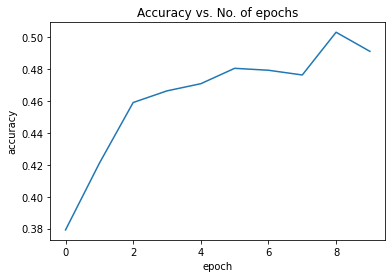

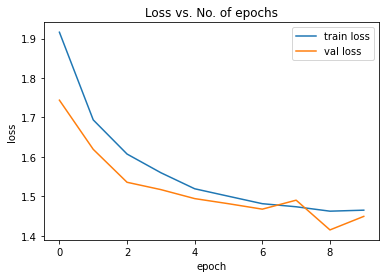

In [94]:
df = pd.DataFrame.from_dict(data_tinyVGG)
fig1 = plt.figure("Figure 1")
plot_acc(data_tinyVGG)
fig2 = plt.figure("Figure 2")
plot_loss(data_tinyVGG)

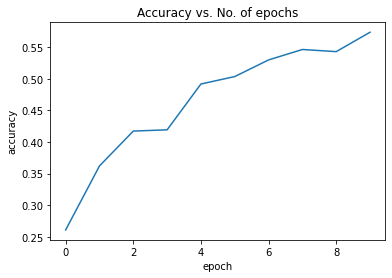

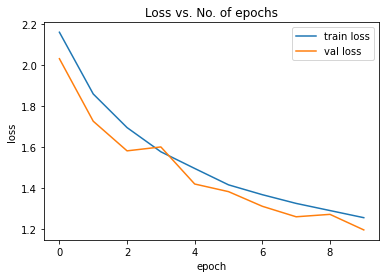

In [95]:
df = pd.DataFrame.from_dict(data_VGG3)
fig1 = plt.figure("Figure 1")
plot_acc(data_VGG3)
fig2 = plt.figure("Figure 2")
plot_loss(data_VGG3)

After 10 epochs, we observe that TinyVGG loss and accuracy graphs shows signs of plateau, indicating potential underfitting of the data. This can be explained by the smaller number of features used (`out_channels=10` for every `nn.Conv2d` layer) as compared to the more sophisticated architecture of VGG3. This suggests VGG3 may be the more powerful CNN model.

Both validation loss and train loss for both models suggest no overfitting of data yet. More epochs needed to determine point of inflexion as when overfitting occurs.

For future consideration:
- Adding more convolutional layers to our model
- increasing the number of channels in each convolutional layer
- regularization techniques.





## Save and Load Models

In [97]:
torch.save(model_0.state_dict(), './drive/MyDrive/cifar10-cnn-tinyVGG.pth')
torch.save(model_1.state_dict(), './drive/MyDrive/cifar10-cnn-VGG3.pth')

# to load model, create instance from the appropriate class
loaded_model = VGG3(input=3, output=OUTPUT_CLASSES).to(DEVICE)
loaded_model.load_state_dict(torch.load('./drive/MyDrive/cifar10-cnn-VGG3.pth'))

<All keys matched successfully>

## Predicting With Unseen Test Set

Use `predict_images(model)` to look at how our model predicts on unseen images. Note that test set is not use in model evaluation. (*not to be confused with cross validation set*)

In [145]:
# there are 10000 samples in the test set
test_batch = unpickle('./data/cifar-10-batches-py/test_batch')
X_test = test_batch[b'data'].reshape(10000, 3, 32, 32) 
y_test = np.array(dict_batch[b'labels'])
y_test

array([1, 8, 5, ..., 9, 1, 1])

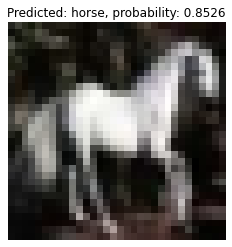

In [172]:
import random

def predict_images(model):
  rand_idx = random.randint(0, len(y_test))
  img, class_idx = X_test[rand_idx], y_test[rand_idx]
  tensor_img = torch.tensor(img)
  plt.imshow(tensor_img.permute(1, 2, 0))

  y_pred_logit = model(tensor_img.unsqueeze(0).type(torch.float32).to(DEVICE))
  y_pred = torch.softmax(y_pred_logit, dim=1).max(dim=1)
  
  out_class, out_prob = y_pred.indices.item(), y_pred.values.item()
  plt.axis(False)
  plt.title(f"Predicted: {name_labels[out_class]}, probability: {out_prob:.4f}")

predict_images(loaded_model)